<span style="color:red">**To run this notebook, the Morello-group version of QCoDeS needs to be installed, as it is not up to date with the latest official QCoDeS version**</span>.

In [1]:
# Initialize packages
import numpy as np
from matplotlib import pyplot as plt

import qcodes as qc
import silq
from silq.instrument_interfaces import Channel
from silq.pulses import SinePulse, TriggerPulse, PulseImplementation, PulseSequence

%matplotlib notebook

<IPython.core.display.Javascript object>

# Introduction

SilQ is a measurement software package that is developed by the Morello group in Sydney.
It utilizes the [QCoDeS measurement software](https://github.com/QCoDeS/Qcodes), and provides added functionality and layers of complexity.
While the actual measurement code is specific to the Morello group, most of SilQ is kept general and should be usable by other groups with minimal modifications.

At the heart of SilQ is the `Layout` architecture, which translates setup-independent generic measurement code to setup-specific Instrument instructions (see image below).
The `Layout` is a meta-instrument that has information about the experimental setup. 
This includes `Instruments` and the physical connectivity between them.
Given a `PulseSequence` with `Pulses` (which are completely setup-independent), the `Layout` can determine which `Instrument` should output each `Pulse`, and distribute them accordingly.
Once distributed, each `Instrument` should be programmed such that it outputs/measures the pulses that it has been given.
This is done by adding an intermediate `Interface` for each `Instrument`.
The `Interface` is used to translate these generic pulses into instructions specific to its `Instrument`.
The `Interface` also reports back to the `Layout` if additional pulses, such as triggering pulses, are necessary, which the `Layout` then passes along to its triggering `Instrument`.

Using this architecture, measurement code can be written that is setup-independent, and can therefore be used in completely different setups without requiring any modifications.
This also greatly simplifies rewiring the setup, or replacing an instrument by another.

To demonstrate the functionality of the Layout architecture, we create a mock setup (shown below) that consists of three instruments:

1. An acquisition instrument
2. A arbitrary waveform generator (AWG)
3. A triggering instrument that triggers the waveform generator

We then create a Layout that connects these instruments, and show that a generic `PulseSequence` can be converted to an actual measurement. 

The bottom of this notebook shows additional information about all the different classes.

![Layout architecture](Layout_architecture.png "Logo Title Text 1")

# Instrument interfaces

Each `Instrument` has a corresponding `Interface`, which performs the translation from instructions given by the `Layout` to actual instructions to the `Instruments`.
As an example, the `Layout` calls `Interface.setup`, after which the `Interface` should use the pulses in its `Interface.pulse_sequence`, and convert it to commands to set up the underlying `Instrument`.

This section sets up the dummy instruments and creates associated interfaces for each of the three instruments.

### Mock interface
We start with a base `MockInterface` class, which implements some basic functionality that each interface should have.
These functions are called by the Layout.
Usually these functions perform operations on the `Instrument`, but since we use dummy instruments, these functions are now left blank.

In [2]:
class MockInterface(silq.instrument_interfaces.InstrumentInterface):
    def setup(self, **kwargs):
        """ Setup the underlying instrument. Usually here Interface.pulse_sequence 
            is converted to actual Instrument instructions """
        pass
    
    def start(self):
        """ Start the underlying Instrument, i.e. run the PulseSequence/wait for triggers """
        pass
    
    def stop(self):
        """ Stop the underlying Instrument """
        pass
    
    def get_final_additional_pulses(self, **kwargs):
        """ Specify if additional pulses are necessary (such as a pre-trigger)
            This is sometimes necessary when additional pulses can only be determined once 
            it knows all of the pulses it needs to implement, e.g. a final trigger at the end of the sequence."""
        return []

### Acquisition interface
The `AcquisitionInterface` is the interface for an `Instrument` that can acquire data.
An Acquisition Interface additionally needs the parameters `acquisition_channels` and `acquisition`.

In [3]:
class AcquisitionInterface(MockInterface):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Define channels (single acquisition channel)
        self._channels = {'ch1': Channel(name='ch1', input=True, 
                                         instrument_name=self.instrument_name()),
                          'ch2': Channel(name='ch2', input=True, 
                                         instrument_name=self.instrument_name())}
        
        # Create a parameter that allows you to choose what channels are acquired
        self.add_parameter('acquisition_channels',
                           parameter_class=qc.ManualParameter,
                           initial_value=['ch1'],
                           vals=qc.utils.validators.Anything())
        
        # Add parameter that performs an acquisition
        self.add_parameter('acquisition',
                           names=['ch1_signal'],
                           shapes=((),),
                           interface=self,
                           parameter_class=InterfaceAcquisitionParameter)
        
    def setup(self, **kwargs):
        self.sample_rate = 1000 # kHz
        self.signal = np.zeros(self.pulse_sequence().duration * self.sample_rate)
        self.acquisition.shapes = [(len(self.signal), )]
        
    def receive_pulse(self, pulse):
        """ This function is used to simulate receiving a pulse from another instrument
            This is only needed for this example and is not used in actual interfaces"""
        
        # Find start and stop idx for the signal
        start_idx = pulse.t_start * self.sample_rate
        stop_idx = pulse.t_stop * self.sample_rate
        # Create time list for pulse
        t_list = np.linspace(pulse.t_start, pulse.t_stop, stop_idx - start_idx)
        
        # Update self.signal to pulse signal when pulse is active
        self.signal[start_idx:stop_idx] = pulse.get_voltage(t_list)
        
    def _acquisition(self):
        """ Perform an acquisition and return the signal """
        return [self.signal]
    
# Create an Acquisition parameter, as it is a MultiParameter 
# and must therefore be subclassed
class InterfaceAcquisitionParameter(qc.MultiParameter):
    def __init__(self, interface, **kwargs):
        super().__init__(**kwargs)
        self.interface = interface
        
    def get(self):
        return self.interface._acquisition()
    
# Create instrument and associated interface
acquisition_instrument = qc.Instrument(name='acquisition')
acquisition_interface = AcquisitionInterface(instrument_name='acquisition')

### AWG interface
We assume that the `AWG Instrument` is capable of outputting a sinusoidal pulse, and so we add a `PulseImplementation` for a `SinePulse`.
When the Layout needs to find a suitable instrument to output a sine pulse, it will look in `Interface.pulse_implementations` to see which instruments are capable of outputting such a pulse.

In this example, we assume that the AWG will need a trigger at the start of the sine pulse.
This is shown in `SineImplementation.target_pulse`, where an additional `TriggerPulse` is specified, which is then returned back to the `Layout`.
The `Layout` will then send this `TriggerPulse` to the instrument that triggers the AWG.

In [4]:
class AWGInterface(MockInterface):
    def __init__(self, target_interface, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Define channels (trigger input, single output)
        self._channels = {'trig_in': Channel(name='trig_in', input_trigger=True,
                                             instrument_name=self.instrument_name()),
                          'ch1': Channel(name='ch1', output=True, 
                                         instrument_name=self.instrument_name())}
        
        # Add pulse implementation for Sine Pulse
        self.pulse_implementations = [
            SineImplementation(
                # Ensure that pulse frequency is not higher than 5 MHz
                pulse_requirements=[('frequency', {'max':5e6})])]
        
        # Since we don't use actual instruments, we pass a target_interface 
        # to which we simulate the sending of pulses
        self.target_interface = target_interface
        
    def receive_pulse(self, pulse):
        # This function is used to simulate receiving a pulse from another instrument
        # As we receive a trigger pulse, we find the corresponding triggered pulse (sine)
        pulse = self.pulse_sequence().get_pulse(t_start=pulse.t_start)
        
        # Send this pulse to the target interface (acquisition interface)
        self.target_interface.receive_pulse(pulse)
        
        
# Create an AWG-specific implementation for the Sine Pulse
class SineImplementation(PulseImplementation, SinePulse):
    def __init__(self, **kwargs):
        PulseImplementation.__init__(self, pulse_class=SinePulse, **kwargs)
    
    def target_pulse(self, pulse, interface, **kwargs):
        # Target the generic pulse to this specific interface
        targeted_pulse = PulseImplementation.target_pulse(
            self, pulse, interface=interface, **kwargs)
        
        # Add a trigger requirement, which is sent back to the Layout
        targeted_pulse.additional_pulses.append(
            TriggerPulse(t_start=pulse.t_start,
                         duration=1e-3,
                         connection_requirements={
                             'input_instrument': interface.instrument_name(),
                             'trigger': True}))
        return targeted_pulse
    
    def implement(self, **kwargs):
        """ This function is called during Interface.setup and performs the actual implementation of the pulse.
            In this case it would output a sinusoidal waveform with a specific sampling rate """
        pass
    
# Create instrument and associated interface
AWG_instrument = qc.Instrument('AWG')
AWG_interface = AWGInterface(instrument_name='AWG', 
                             target_interface=acquisition_interface)

### Trigger interface
A trigger instrument can output trigger pulses to other instruments.
As such, it has an implementation for a `TriggerPulse`.

In this case, we assume it only needs to trigger the AWG, and only has one output channel

In [5]:
class TriggerInterface(MockInterface):
    def __init__(self, target_interface, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Define channels (single output)
        self._channels = {'ch1': Channel(name='ch1', output=True, 
                                         instrument_name=self.instrument_name())}
        
        # Add pulse implementation for Trigger Pulse
        self.pulse_implementations = [
            TriggerImplementation()]
        
        # Since we don't use actual instruments, we pass a target_interface 
        # to which we simulate the sending of pulses
        self.target_interface = target_interface
    
    def start(self):
        # The instrument should start triggering.
        # We simulate this by 'sending' pulses.
        # In reality, pulses are actually applied via hardware connections
        for pulse in self.pulse_sequence():
            self.target_interface.receive_pulse(pulse)


# Create an implementation for the Trigger pulse that is specific to this interface
class TriggerImplementation(PulseImplementation, TriggerPulse):
    def __init__(self, **kwargs):
        PulseImplementation.__init__(self, pulse_class=TriggerPulse, **kwargs)
    
            
# Create a dummy instrument that is supposed to be the triggering instrument
trigger_instrument = qc.Instrument('trigger')
# Create an associated interface, which finds 'trigger_instrument'
# by searching for an instrument with that name
trigger_interface = TriggerInterface(instrument_name='trigger',
                                     target_interface=AWG_interface)

# Layout
The Layout is the meta-instrument that connects the various `Instruments` via `Connections`.
It communicates with Instruments via `Interfaces`, meaning that it sends generic commands to the interfaces, which then translate it to specific Instruments.
The Layout can tailor a setup-independent `PulseSequence` to the experimental setup, and configure the `Instruments` such that the `PulseSequence` is actually implemented. This section will go through the process of setting up the Layout, an performing a measurement.

The first step is to create the Layout, and specify the connectivity between the instruments.

In [6]:
from silq.meta_instruments.layout import Layout

layout = Layout(name='layout', 
                instrument_interfaces=[acquisition_interface, 
                                       AWG_interface, 
                                       trigger_interface])

# Specify the acquisition instrument
layout.acquisition_instrument('acquisition')

layout.acquisition_outputs([('AWG.ch1', 'output')])

In [7]:
layout.add_connection(output_arg='trigger.ch1',
                      input_arg='AWG.trig_in', trigger=True)
layout.add_connection(output_arg='AWG.ch1',
                      input_arg='acquisition.ch1')

Connection{AWG.ch1->acquisition.ch1}()

Alternatively you can load connections from the QCoDeS config

In [8]:
qc.config.user.connections = [
    {'output_arg': 'trigger.ch1',
     'input_arg': 'AWG.trig_in',
     'trigger': True},
    {'output_arg': 'AWG.ch1',
     'input_arg': 'acquisition.ch1'}
]
layout.load_connections()

Once the Layout is correctly setup, including the connectivity between Instruments, a pulse sequence can be targeted to the experimental setup. In this example, the PulseSequence consists of two sine waves with different frequencies.
These pulses are combined in a PulseSequence, which is still completely setup-independent.

<IPython.core.display.Javascript object>


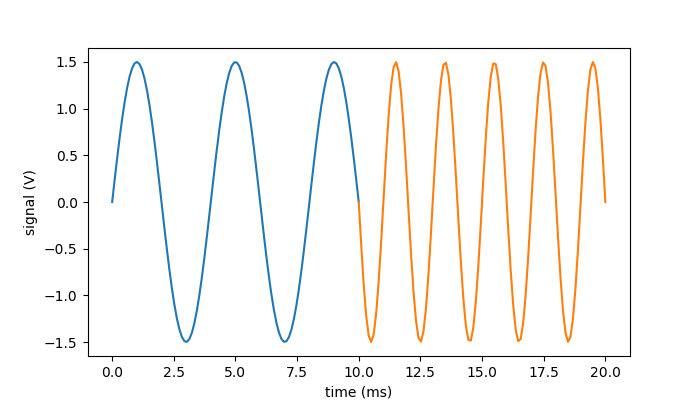

In [9]:
# Create two sine waves with different frequencies. 
# Note the kwarg acquire=True, which indicates that they should be acquired
# If the second pulse does not get a t_start, it automatically starts at the end of the previous pulse.
sine_pulse1 = SinePulse(name='sinewave1', t_start=0, duration=10, 
                       frequency=250, power=1.5, phase=0, acquire=True)
sine_pulse2 = SinePulse(name='sinewave2', duration=10, 
                       frequency=500, power=1.5, phase=180, acquire=True)
pulse_sequence = PulseSequence(pulses=[sine_pulse1, sine_pulse2])

# Plot pulses
plt.figure(figsize=(7,4))
plt.xlabel('time (ms)')
plt.ylabel('signal (V)')
for pulse in pulse_sequence:
    t_list = np.linspace(pulse.t_start, pulse.t_stop, 100) # ms
    voltages = pulse.get_voltage(t_list)
    plt.plot(t_list, voltages)

The PulseSequence can then be passed to the Layout, which distributes the pulses to the interfaces. 
Here, each `Pulse` is directed to a specific `Connection`, and is sent to the input and output interfaces of that `Connection`.
Finding the suitable `Connection` is done by checking which `Interfaces` can implement the given `Pulse`.

At this stage, Instruments may need additional pulses, such as triggering pulses.
The interface will send these pulses to the Layout, which will then determine the triggering Instrument and send the pulse to the corresponding Interface.

In [10]:
layout.target_pulse_sequence(pulse_sequence)

After targeting, each Interface has a PulseSequence which has information on the pulses it should implement.
Here we see that the AWG needs to implement two sine pulses.

In [11]:
AWG_interface.pulse_sequence()

PulseSequence with 2 pulses, duration: 20
	SineImplementation(sinewave1, f=0.00 MHz, power=1.5, t_start=0, t_stop=10
		connection: Connection{AWG.ch1->acquisition.ch1}()
		additional_pulses:
		TriggerPulse(None, t_start=0, duration=0.001
			requirements: {'input_instrument': 'AWG', 'trigger': True}))
	SineImplementation(sinewave2, f=0.00 MHz, power=1.5, t_start=10, t_stop=20
		connection: Connection{AWG.ch1->acquisition.ch1}()
		additional_pulses:
		TriggerPulse(None, t_start=10, duration=0.001
			requirements: {'input_instrument': 'AWG', 'trigger': True}))

Similarly, we see that the trigger instrument needs to output two trigger pulses, one for each sine pulse

In [12]:
trigger_interface.pulse_sequence()

PulseSequence with 2 pulses, duration: 20
	TriggerImplementation(None, t_start=0, duration=0.001
		connection: Connection{trigger.ch1->AWG.trig_in}(, trigger)
		requirements: {'input_instrument': 'AWG', 'trigger': True})
	TriggerImplementation(None, t_start=10, duration=0.001
		connection: Connection{trigger.ch1->AWG.trig_in}(, trigger)
		requirements: {'input_instrument': 'AWG', 'trigger': True})

Once the PulseSequence has been targeted to the experimental setup, the Instruments need to be configured such that they actually output the distributed PulseSequence.
This is done by calling `Layout.setup()`, which then calls `Interface.setup()` for each of its interfaces.

In [13]:
layout.setup()

Finally, an acquisition can be performed, which is done by calling `Layout.do_acquisition`.
First all the instruments are started, after which the acquisition interface starts acquiring data.

Below we see that the acquisition interface indeed received the two sine pulses.

<IPython.core.display.Javascript object>


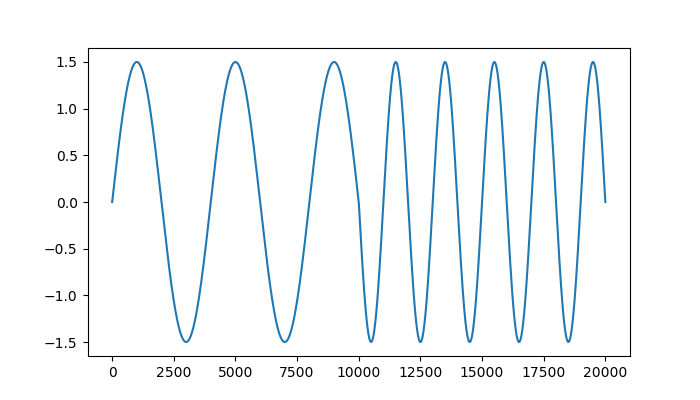

In [14]:
signals = layout.do_acquisition(return_dict=True)

plt.figure(figsize=(7,4))
plt.plot(signals['acquisition_traces']['output'])

This concludes our introduction to the Layout architecture.
We have shown how interfaces can be created for the different instruments, and how they can be connected through the Layout.
A setup-independent PulseSequence was then given to the Layout, which distributed the pulses to the experimental setup and configured the Instruments through their interfaces such the the resulting signal correctly measured the two sinusoidal waves.

Using this architecture, measurement code can be written that is more generic.
This enables use of the same measurement code in completely different setups.


## Additional information

### Interface
- Interfaces are initialized by passing along the name of the underlying instrument.
- `Interface.channels` contains all the channels of its Instrument. This is used when creating connections between interfaces through the Layout. Channels can have properties, such as whether it is an `input`, `output` `trigger` channel etc.
- An `Interface` has both an `input_pulse_sequence` and an (output) `pulse_sequence`. The `input_pulse_sequence` contains all the pulses it receives from other Instruments, while the `pulse_sequence` contains pulses it outputs to other instruments. Both are parameters, as this ensures that it is saved during snapshots and is compatible with the multiprocessing architecture. Due to this constraint, performing operations such as adding a pulse requires passing a tuple ('add', {pulse}). See `Interface._set_pulse_sequence` for more info.
- The attribute `Interface.instrument` contains the underlying instrument of the interface

### Pulse implementation
A `PulseImplementation` is meant to implement a generic pulse for a specific `Instrument`.
Each `PulseImplementation` is specific to a certain `Pulse`, and is a child of both the `Pulse` it implements, as well as the base `PulseImplementation` class.

A `PulseImplementation` generally has three main stages:
- `__init__`: Initialize the parent class `PulseImplementation`. Initialization is only done for `Interface.pulse_implementation`, such that it has a list of all pulse implementations (see below). Note that it does not initialize the `Pulse` class, and therefore does not have the same properties as the `Pulse`. 
- `target_pulse`: Receives a pulse, and tailors the implementation to that specific pulse. The `PulseImplementation` now looks nearly identical to the untargeted pulse, except that it also has an implementation for a specific Instrument
- `implement`: This function is called during `Interface.setup`, and implements the pulse for a specific `Instrument`. This stage is highly specific for each Instrument; in some cases, Interfaces need more of the `Instrument` configuration in `Interface.setup`, while others need most configuration in `Pulseimplementation.setup`.

`Interface.pulse_implementations` is a list containing `PulseImplementations`. This is used for two reasons
  - Converting an abstract pulse to targeted instructions for the underlying Instrument. 
    As Instruments are setup in different ways, it should be decided per Instrument how to use a PulseImplementation to perform this conversion (look in existing Interfaces for examples).
  - As a means for the Layout to determine which Instrument a pulse should be directed to. 
    A Layout usually receives abstract pulses containing no information about actual Instruments.
    When the Layout targets an abstract pulse sequence, it checks for each pulse which interface can implement the given pulse.
    It does so by looking at its pulse_implementations.
    
### Layout
- The Layout should be created after all Interfaces are created, as it receives the Interfaces as an argument during initialization.
- Interfaces that have no pulse sequence after targeting of PulseSequence are not taken into account during setup, start, and stop

### Connections
- Connections are defined through `Layout.add_connection`. By default, a `Connection` is a `SingleConnections`, which refer to the connection being a single physical connection.
- Several `SingleConnections` can be combined using `Layout.combine_connections`, resulting in a `CombinedConnection`. This is useful in cases where pulses always need to be sent through multiple connections simultaneously (such as when using compensated pulses).
- When a Layout finds multiple connections that can implement the same pulse, it will check if any of them have the property`default=True`. If so, it will send the pulse to that connection. This may not be the optimal solution, and is subject to change.
- Connections can have a scale, which accounts for attenuation in the cable. The 'CombinedConnection' also has a scale, which determines the compensation factor.
- The user generally does not touch Connections. This is done internally by the Layout and Interfaces